In [1]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Categorical
import random
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Callable, Type, Any
from IPython.display import clear_output


In [31]:

def find_indeces(coords, space_size, state_size):
    scale = state_size/space_size
    index_list = []
    for line in coords:
        indeces = [int(line[0]*scale), int(line[1]*scale)]
        index_list.append(indeces)

    return index_list

class BoxCad_1d:
    """Box Cad 1d environment.
  box CAD is a simplified CAD 1d environment for agent training.
  When the environment is reseted, env creates a task for the agent:
    1) updates the space (removes all geometry from the previous episode).
    2) creates lines-tasks in space that the body of the construction must reach;
    3) creates the current working line

  Available operations with the construction line:
  - create a new line (in the future !!!!)
  - independently move the points of working line.

  The oservation is a pytorch tensor, interpreted as a geometric space.
  It looks like |000000111111100000|
  two options are available:
  1) self.multichannel = False. Paytorch tensor size (2, state_size). 
    - there are three one-dimensional spaces. The first space is the space of details, 
    the value of the elements in the tensor: 
      1 - if there is the current working line;
      0 - if not. 
    The second space is the task space, the value of the tensor elements: 
      1 - if there is a task body, 
      0 - if not. 
  2) self.mutechannel = True. Paytorch tensor size (state_size). 
    All bodies are in one space at once, the values of the elements
    are equal to the sum of the elements from the previous case through 
    weighting coefficients.

  Actions:
  full list of actions - range(0, 4).
    0 - move the right point of working line to the right;
    1 - move the right point of working line to the left;
    2 - move the left point of working line to the right;
    3 - move the left point of working lone to the left.

  Rewards. 
    1 if working line achieved the task point;
    0 if doesn't;
    -1 if the task point is inside the working line.
    """

    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_size = 32
        self.space_size = 100
        self.moving_step = 5
        self.max_index = 100

        self.mesh_space = np.arange(0, self.space_size+self.moving_step, self.moving_step)

        self.multichannel = False

        if self.multichannel:
            self.working_space = torch.zeros(2, self.state_size).to(self.device)

        else:
            self.working_space = torch.zeros(self.state_size).to(self.device)

        self.task_lines = None
        self.current_line = torch.tensor([0, 0]).to(self.device)

        self.workspace_tasks = torch.zeros(self.state_size).to(self.device)
        self.workspace_current_line = torch.zeros(self.state_size).to(self.device)

        self.touched_points_indeces = []

        self.current_objective = 0
        self.action = None

        self.generate_tasks()
        self.generate_working_line()
        self.calculate_objective()
        self.update_workspace()

        self.zero_length_flag = False
        self.done_flag = False
        self.current_index = 0


    def reset(self):
        # print('reset')
        if self.multichannel:
            self.working_space = torch.zeros(2, self.state_size).to(self.device)

        else:
            self.working_space = torch.zeros(self.state_size).to(self.device)

        self.task_lines = None
        self.current_line = torch.tensor([0, 0]).to(self.device)

        self.workspace_tasks = torch.zeros(self.state_size).to(self.device)
        self.workspace_current_line = torch.zeros(self.state_size).to(self.device)

        self.current_objective = 0
        self.touched_points_indeces = []
        self.action = None

        self.generate_tasks()
        self.generate_working_line()
        self.calculate_objective()
        self.update_workspace()

        self.zero_length_flag = False
        self.done_flag = False
        self.current_index = 0 

    def check_ability_to_touch(self):
        pass

    def update_workspace_task(self):
        self.workspace_tasks *= 0
        indeces = find_indeces(self.task_lines, self.space_size, self.state_size) # [[x_11, x_12], [x_21, x_22]]
        for line in indeces:
            self.workspace_tasks[line[0]:line[1]] = 1

    def update_workspace_current_line(self):
        self.workspace_current_line *= 0
        indeces = find_indeces(self.current_line[None, :], self.space_size, self.state_size)
        self.workspace_current_line[indeces[0][0]:indeces[0][1]] = 1

    def generate_tasks(self, mesh_size=10, offset=20):
        # define the number of boxes
        number_of_task_point = random.sample([1, 2], k=1)[0]
        # print(number_of_task_point)

        # self.task_lines = torch.tensor(number_of_task_point, 2).to(self.device)
        # generate ranodm points in the first third of space and withing the last third of space
        working_bool_indeces_first_point = (self.mesh_space<self.space_size/3) * (self.mesh_space>self.space_size/10)
        working_bool_indeces_second_point = (self.mesh_space>self.space_size*2/3) * (self.mesh_space<self.space_size*9/10)
        working_space_first_point = self.mesh_space[working_bool_indeces_first_point]
        working_space_second_point = self.mesh_space[working_bool_indeces_second_point]

        first_point = np.random.choice(working_space_first_point, 1, False)[0]
        second_point = np.random.choice(working_space_second_point, 1, False)[0]

        # print(first_point)
        # print(second_point)

        if number_of_task_point == 1:
            point = random.sample([first_point, second_point], k=1)[0]
            
            # generate offset
            if point >= self.space_size/2:
                self.task_lines = torch.tensor([[point, point+offset]]).to(self.device)
                
            else:
                self.task_lines = torch.tensor([[point-offset, point]]).to(self.device)
                
        else:
            # generate offset
            self.task_lines = torch.tensor([[first_point-offset, first_point], [second_point, second_point+offset]]).to(self.device) 

        # print("task lines", self.task_lines)
        # print("space size", self.space_size)
        # cut if the second point out of space
        self.task_lines = torch.clip(self.task_lines, 0, self.space_size)

        self.update_workspace_task()
        # update workspace task

    def generate_working_line(self, mesh_size=10):
        # select two points within the second third of space
        working_space = self.mesh_space[self.mesh_space>self.space_size*2/5]
        working_space = working_space[working_space<self.space_size*3/5]
        working_points = np.random.choice(working_space, 2, False)

        # sort them
        working_points = np.sort(working_points)

        # update parameters
        self.current_line[0] = working_points[0]
        self.current_line[1] = working_points[1]

        self.update_workspace_current_line()

    def transform_working_line(self, moving_action):
        """
        Actions:

            0 - move the right point of working line to the right;
            1 - move the right point of working line to the left;
            2 - move the left point of working line to the right;
            3 - move the left point of working lone to the left.

        """
        # decode moving case
        move_parametes = [[1, 1], [1, -1], [0, 1], [0, -1]]
        moving_case = move_parametes[moving_action]

        # transforme current line
        new_line = self.current_line[:]
        new_line[moving_case[0]] = new_line[moving_case[0]] + self.moving_step*moving_case[1]
        # !!!! solve the problem with zero length

        # update if new line is not zero length 
        # !!!!!!!!!!!!May be it is necessary to update the current line anyway
        # print('New line', new_line)
        if new_line[0] != new_line[1]:
            self.current_line = new_line
            self.update_workspace_current_line()
            self.zero_length_flag = False

        else:
            self.zero_length_flage = True
            new_line[moving_case[0]] = new_line[moving_case[0]] - self.moving_step*moving_case[1]

        self.update_workspace()
        self.calculate_objective()

    def calculate_objective(self):
        ### For the policy method from homework the best result is zero
        # so we will return the sum of distant to the task point and doubled overlaping length

        # calulate the distant to the task points
        dist = 0
        # print(self.task_lines.size())

        if self.task_lines.size()[0] == 2:

            dist_1 = self.current_line[0] - self.task_lines[0, 1]
            if dist_1 < 0: # overlap
                dist_1 = dist_1 * (-2)
            dist_2 = self.task_lines[1, 0] - self.current_line[1]
            if dist_2 < 0: #overlap
                dist_2 = dist_2 * (-2)
            dist = dist_1+dist_2

        else:
            if self.task_lines[0, 0] < self.space_size/2:
                dist = self.current_line[0] - self.task_lines[0, 1]
            else:
                dist = self.task_lines[0, 0] - self.current_line[1]

            if dist < 0:
                dist = dist * (-2)

            # print("Dist", dist)

        if dist == 0:
            self.done_flag = True

        self.current_objective = dist

    def update_workspace(self):

        if self.multichannel:
            # self.working_space = torch.zeros(2, self.state_size).to(self.device)
            self.working_space[0] = self.workspace_current_line
            self.working_space[1] = self.workspace_tasks

        else:
            # self.working_space = torch.zeros(self.state_size).to(self.device)
            self.working_space *= 0
            self.working_space = self.workspace_tasks + 0.5 * self.workspace_current_line

    def receive_action(self, action):
        self.action = action

    def step(self):

        # if self.done_flag == False and self.current_index < self.max_index:
        #     # print(self.action)
        #     self.transform_working_line(self.action)
        #     self.current_index += 1
        #     return True
        
        # else:
        #     # print("step stop", self.done_flag, self.current_index) 
        #     return False
        
        if self.done_flag or self.current_index > self.max_index:
            return False
        
        else:
            self.transform_working_line(self.action)
            self.current_index += 1
            return True


    def get_sim_step_data(self):
        
        return (self.working_space, self.action, self.current_index)

    def render(self, plot_rendering=True):
        # print(self.working_space)

        if plot_rendering:
            task_mat = self.workspace_tasks[None, :].cpu()
            current_line_mat = self.workspace_current_line[None, :].cpu()
            # print(task_mat)

            plt.spy(task_mat, precision=0.1, markersize=16, c="green")
            plt.spy(current_line_mat, precision=0.1, markersize=16, c="gold")

            plt.show()
            


        

In [38]:


class IterationBuffer(Dataset):
    """Buffer for experience replay"""

    def __init__(self) -> None:
        """Initialize `IterationBuffer`"""

        super().__init__()
        self.next_baselines = None
        self.nullify_buffer()
        self.debug_flag = True

    def nullify_buffer(self) -> None:
        """Clear all buffer data"""
        # print('Clear buffer')

        self.episode_ids = []
        self.observations = []
        self.actions = []
        self.running_objectives = []
        self.step_ids = []
        self.total_objectives = None
        self.baselines = None

    def add_step_data(
        self,
        observation: np.array,
        action: np.array,
        running_objective: float,
        step_id: int,
        episode_id: int,
    ):
        """Add step data to experience replay

        Args:
            observation (np.array): current observation
            action (np.array): current action
            running_objective (float): current running objective
            step_id (int): current step
            episode_id (int): current episode
        """
        self.observations.append(observation)
        self.actions.append(action)
        self.running_objectives.append(running_objective)
        self.episode_ids.append(int(episode_id))
        self.step_ids.append(step_id)

    def get_N_episodes(self) -> int:
        """Get number of episodes

        Returns:
            int: number of episodes
        """
        return len(np.unique(self.episode_ids))

    def calculate_tail_total_objectives_and_next_baselines(
        self,
    ) -> Tuple[np.array, float, float]:
        """Calculate tail total costs and baseline

        Returns:
            Tuple[np.array, float, float]: tuple of 3 elements tail_total_objectives, baseline, gradent_normalization_constant
        """

        unique_episode_ids, counts = np.unique(self.episode_ids, return_counts=True)
        running_objectives_series = pd.Series(
            index=self.episode_ids, data=self.running_objectives
        )

        # print('___________________________')
        # print(unique_episode_ids)
        # print(counts)
        # print('_____________________________')
        debug_flag = True
        if debug_flag:
            debug_flag = False
            # print("__________________")
            # print("running_obj_series")
            # print(self.running_objectives)
            # print(self.episode_ids)
            # print(running_objectives_series)
            # print(unique_episode_ids)
            # print('running_obj_example', running_objectives_series.loc[3][::-1].cumsum()[::-1])

        

        tail_total_objectives = pd.concat(
            [
                running_objectives_series.loc[i][::-1].cumsum()[::-1]
                for i in unique_episode_ids
            ]
        ).values.reshape(-1)

        next_baselines = (
            pd.Series(index=self.step_ids, data=tail_total_objectives)
            .groupby(level=0)
            .mean()
            .loc[self.step_ids]
            .values.reshape(-1)
        )

        return tail_total_objectives, next_baselines

    def __len__(self) -> int:
        """Get length of buffer. The method should be overrided due to inheritance from `torch.utils.data.Dataset`

        Returns:
            int: length of buffer
        """
        # return len(self.observations)
        if self.next_baselines is not None:
            return min(len(self.observations), self.next_baselines.size)
        else:
            return len(self.observations)

    def __getitem__(self, idx: int) -> Dict[str, torch.tensor]:
        """Get item with id `idx`. The method should be overrided due to inheritance from `torch.utils.data.Dataset`

        Args:
            idx (int): id of dataset item to return

        Returns:
            Dict[str, torch.tensor]: dataset item, containing catted observation-action, tail total objective and baselines
        """

        if self.total_objectives is None:
            self.baselines = (
                self.next_baselines
                if self.next_baselines is not None
                else np.zeros(shape=len(self.observations))
            )
            # print('Update baseline')
            (
                self.total_objectives,
                self.next_baselines,
            ) = self.calculate_tail_total_objectives_and_next_baselines()

        observation = torch.tensor(self.observations[idx])
        action = torch.tensor(self.actions[idx])
        self.debug_flag = True
        if self.debug_flag:
            self.debug_flag = False
            # print('Debug from dataloader')
            # print("Observation size", len(self.observations))
            # print('Action size', len(self.actions))
            # print('Total obj size', self.total_objectives.size)
            # print('baselines size', self.baselines.size)

        return {
            "observations_actions": torch.cat([observation, action]),
            "tail_total_objectives": torch.tensor(self.total_objectives[idx]),
            "baselines": torch.tensor(self.baselines[idx]),
        }

    @property
    def data(self) -> pd.DataFrame:
        """Return current buffer content in pandas.DataFrame

        Returns:
            pd.DataFrame: current buffer content
        """

        return pd.DataFrame(
            {
                "episode_id": self.episode_ids,
                "step_id": self.step_ids,
                "observation": self.observations,
                "action": self.actions,
                "running_objective": self.running_objectives,
            }
        )

In [39]:
class RLModel(nn.Module):

    def __init__(
        self,
        dim_observation: int,
        dim_action: int,
        dim_hidden: int,
        std: float,
        scale_factor: float,
        leakyrelu_coef=0.2,
    ):
        """Initialize model.

        Args:
            dim_observation (int): dimensionality of observation
            dim_action (int): dimensionality of action
            dim_hidden (int): dimensionality of hidden layer of perceptron (dim_hidden = 4 works for our case)
            std (float): standard deviation of noise (\\sigma)
            action_bounds (np.array): action bounds with shape (dim_action, 2). `action_bounds[:, 0]` - minimal actions, `action_bounds[:, 1]` - maximal actions
            scale_factor (float): scale factor for last activation (L coefficient) (see details above)
            leakyrelu_coef (float): coefficient for leakyrelu
        """

        super().__init__()

        self.dim_observation = dim_observation
        self.dim_action = dim_action
        self.dim_hidden = dim_hidden
        self.leakyrelu_coef = leakyrelu_coef
        self.std = std

        self.scale_factor = scale_factor
        self.register_parameter(
            name="scale_tril_matrix",
            param=torch.nn.Parameter(
                (self.std * torch.eye(self.dim_action)).float(),
                requires_grad=False,
            ),
        )

        # https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py#L4


        #-----------------------------------------------------------------------
        # HINT
        #
        # Define your perceptron (or its layers) here
        #
        # TAs used nn.Sequential(...)
        # https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

        # YOUR CODE GOES HERE
        self.model = nn.Sequential(
                            nn.Linear(self.dim_observation, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, self.dim_action),
                            nn.Softmax(dim=-1)
                        )

        #-----------------------------------------------------------------------



    def split_to_observations_actions(
        self, observations_actions: torch.FloatTensor
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Split input tensor to tuple of observation(s) and action(s)

        Args:
            observations_actions (torch.FloatTensor): tensor of catted observations actions to split

        Raises:
            ValueError: in case if `observations_actions` has dimensinality greater than 2

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: tuple of observation(s) and action(s)
        """

        if len(observations_actions.shape) == 1:
            observation, action = (
                observations_actions[: self.dim_observation],
                observations_actions[self.dim_observation :],
            )
        elif len(observations_actions.shape) == 2:
            observation, action = (
                observations_actions[:, : self.dim_observation],
                observations_actions[:, self.dim_observation :],
            )
        else:
            raise ValueError("Input tensor has unexpected dims")

        return observation, action

    def log_probs(self, batch_of_observations_actions: torch.FloatTensor) -> torch.FloatTensor:
        """Get log pdf from the batch of observations actions

        Args:
            batch_of_observations_actions (torch.FloatTensor): batch of catted observations and actions

        Returns:
            torch.FloatTensor: log pdf(action | observation) for the batch of observations and actions
        """

        observations, actions = self.split_to_observations_actions(
            batch_of_observations_actions
        )

        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        #-----------------------------------------------------------------------
        # HINT
        # You should calculate pdf_Normal(\\lambda \\mu_theta(observations) + \\beta, \\lambda ** 2 \\sigma ** 2)(actions)
        #
        # TAs used not NormalDistribution, but MultivariateNormal
        # See here https://pytorch.org/docs/stable/distributions.html#multivariatenormal
        # YOUR CODE GOES HERE
        # print(observations)

        # means = self.get_means(observations)
        # means = torch.squeeze(means)
        # means = self.unscale_from_minus_one_one_to_action_bounds(means)
        # _, lambd = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()
        # lambd = torch.squeeze(lambd)
        # cov_matrix = torch.eye(means.size(0))*(self.std**2)*(lambd**2)
        # actions = torch.squeeze(actions)

        # print(means.size())
        # print(actions.size())
        # print(cov_matrix.size())
        # beta, lambd = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()
        # print(observations)

        # log_probs = MultivariateNormal(lambd * self.get_means(observations) + beta, lambd ** 2 * scale_tril_matrix ** 2).log_prob(actions)

        action_probs = self.model(observations)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()


        return(action_logprobs)
        #-----------------------------------------------------------------------


    def sample(self, observation: torch.FloatTensor) -> torch.FloatTensor:
        """Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)`

        Args:
            observation (torch.FloatTensor): current observation

        Returns:
            torch.FloatTensor: sampled action
        """
        # action_bounds = self.get_parameter("action_bounds")
        # scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        #-----------------------------------------------------------------------
        # HINT
        # Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)
        # YOUR CODE GOES HERE
        # means = self.get_means(observation)
        # means = self.unscale_from_minus_one_one_to_action_bounds(means)
        # beta, lambd = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        # print(scale_tril_matrix)
        # print(observation.size())
        # print(torch.eye(observation.size(0))*(lambd**2 * self.std**2))
        # m = MultivariateNormal(lambd * self.get_means(observation) + beta, lambd ** 2 * scale_tril_matrix ** 2)
        # sampled_action = m.sample()

        action_probs = self.model(observation)
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        #-----------------------------------------------------------------------
        return action

In [40]:
class LRSchedulerSwitch:
    """Callable class that returns True in case ||observation|| <= norm_observation_threshold"""

    def __init__(self, norm_observation_threshold: float) -> None:
        """Initialize LRSchedulerSwitch.

        Args:
            norm_observation_threshold (float): threshold for observation norm
        """
        self.norm_observation_threshold = norm_observation_threshold
        self.turned_on = False

    def __call__(self, observation: np.array) -> bool:
        """Return True if ||observation|| <= norm_observation_threshold

        Args:
            observation (np.array): observation

        Returns:
            bool: ||observation|| <= norm_observation_threshold
        """

        if (
            self.turned_on
            or np.linalg.norm(observation) <= self.norm_observation_threshold
        ):
            self.turned_on = True
            return True
        else:
            return False


class Optimizer:
    """Does gradient step for optimizing model weights"""

    def __init__(
        self,
        model: nn.Module,
        opt_method: Type[torch.optim.Optimizer],
        opt_options: Dict[str, Any],
        lr_scheduler_method: Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        lr_scheduler_options: Optional[Dict[str, Any]] = None,
        lr_scheduler_switch: Callable[[np.array], bool] = lambda _: True,
        shuffle: bool = True,
    ):
        """Initialize Optimizer

        Args:
            model (nn.Module): model which weights we need to optimize
            opt_method (Type[torch.optim.Optimizer]): method type for optimization. For instance, `opt_method=torch.optim.SGD`
            opt_options (Dict[str, Any]): kwargs dict for opt method
            lr_scheduler_method (Optional[torch.optim.lr_scheduler.LRScheduler], optional): method type for LRScheduler. Defaults to None
            lr_scheduler_options (Optional[Dict[str, Any]], optional): kwargs for LRScheduler. Defaults to None
            lr_scheduler_switch (Callable[[np.array], bool]): callable object for turning on the sheduller. Defaults to lambda _: True
            shuffle (bool, optional): whether to shuffle items in dataset. Defaults to True
        """

        self.opt_method = opt_method
        self.opt_options = opt_options
        self.shuffle = shuffle
        self.model = model
        self.optimizer = self.opt_method(self.model.parameters(), **self.opt_options)
        self.lr_scheduler_method = lr_scheduler_method
        self.lr_scheduler_options = lr_scheduler_options
        self.lr_scheduler_switch = lr_scheduler_switch
        if self.lr_scheduler_method is not None:
            self.lr_scheduler = self.lr_scheduler_method(
                self.optimizer, **self.lr_scheduler_options
            )
        else:
            self.lr_scheduler = None

    def optimize(
        self,
        objective: Callable[[torch.tensor], torch.tensor],
        dataset: IterationBuffer,
    ) -> None:
        """Do gradient step.

        Args:
            objective (Callable[[torch.tensor], torch.tensor]): objective to optimize
            dataset (Dataset): data for optmization
        """

        dataloader = DataLoader(
            dataset=dataset,
            shuffle=self.shuffle,
            batch_size=len(dataset),
        )
        batch_sample = next(iter(dataloader))
        self.optimizer.zero_grad()
        objective_value = objective(batch_sample)
        objective_value.backward()
        self.optimizer.step()

        last_observation = dataset.observations[-1]
        if self.lr_scheduler_switch(last_observation) and self.lr_scheduler is not None:
            self.lr_scheduler.step()

In [41]:
class PolicyREINFORCE:
    def __init__(
        self, model: nn.Module, optimizer: Optimizer, device: str = "cpu", is_with_baseline: bool = True,
    ) -> None:
        """Initialize policy

        Args:
            model (nn.Module): model to optimize
            optimizer (Optimizer): optimizer for `model` weights optimization
            device (str, optional): device for gradient descent optimization procedure. Defaults to "cpu".
            is_with_baseline (bool, optional): whether to use baseline in objective function.
        """

        self.buffer = IterationBuffer()
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.is_with_baseline = is_with_baseline

    def objective(self, batch: Dict["str", torch.tensor]) -> torch.tensor:
        """This method computes a proxy objective specifically for automatic differentiation since its gradient is exactly as in REINFORCE

        Args:
            batch (torch.tensor): batch with catted observations-actions, total objectives and baselines

        Returns:
            torch.tensor: objective value
        """

        observations_actions = batch["observations_actions"].to(self.device)
        tail_total_objectives = batch["tail_total_objectives"].to(self.device)
        baselines = batch["baselines"].to(self.device)
        N_episodes = self.N_episodes

        #-----------------------------------------------------------------------
        # HINT
        # Return the surrogate objective value as described above
        # YOUR CODE GOES HERE
        # for i in range(N_episodes):
        # print(observations_actions)
        log_probs = self.model.log_probs(observations_actions) #!!!!!!!!!!!!!!!!!!!!!! check the shape of log_probs
        objective_tensor = (tail_total_objectives - baselines)*log_probs
        objective = objective_tensor.sum()/N_episodes

        # for m in M:

        return objective
        #-----------------------------------------------------------------------

    def REINFORCE_step(self) -> None:
        """Do gradient REINFORCE step"""

        self.N_episodes = self.buffer.get_N_episodes()
        self.model.to(self.device)
        self.optimizer.optimize(self.objective, self.buffer)
        self.model.to("cpu")
        self.buffer.nullify_buffer()

In [46]:
Simulator = BoxCad_1d()

class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator: Simulator,
        # system: InvertedPendulumSystem,
        policy: PolicyREINFORCE,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running objectives. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_objective, total_objectove. Defaults to lambda*args:False
        """

        self.simulator = simulator # the simulato and system are the same
        # self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor

        self.total_objective = 0
        self.total_objectives_episodic = []
        self.learning_curve = []
        self.last_observations = None

    def compute_running_objective(
        self, observation: np.array, action: np.array
    ) -> float:
        """Computes running objective

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running objective value
        """

        return self.simulator.current_objective

    def run(self) -> None:
        """Run main loop"""

        debug_flag = True

        eps = 0.1
        means_total_objectives = [eps]
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            for episode_idx in tqdm(range(self.N_episodes)):
                terminated = False
                # print('Episode idx', episode_idx)

                # self.simulator.receive_action(0)
                (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()
                
                new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                
                self.simulator.receive_action(new_action)

                n_step = 0
                
                while self.simulator.step():
                    (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()

                    new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    discounted_running_objective = self.discount_factor ** (
                        step_idx
                    ) * self.compute_running_objective(observation, new_action)
                    self.total_objective += discounted_running_objective

                    if not terminated and self.termination_criterion(
                        observation,
                        new_action,
                        discounted_running_objective,
                        self.total_objective,
                    ):
                        terminated = True
                        # print('Terminated true', episode_idx)

                    if not terminated:
                        # print("Not teriminated")
                        if debug_flag:
                            # print('____________________________')
                            # print(observation.numpy())
                            # print(np.array([new_action]))
                            # print(discounted_running_objective.numpy())
                            # print(step_idx)
                            # print(step_idx)
                            debug_flag = False
                        self.policy.buffer.add_step_data(
                            np.copy(observation.numpy()),
                            np.copy(np.array([new_action])),
                            np.copy(discounted_running_objective.numpy()),
                            step_idx,
                            episode_idx,
                        )
                    self.simulator.receive_action(new_action)

                    n_step += 1
                # print('reset')
                self.simulator.reset()
                self.total_objectives_episodic.append(self.total_objective)
                self.total_objective = 0
                # print('Episode idx', episode_idx, n_step)

            self.learning_curve.append(np.mean(self.total_objectives_episodic))
            self.last_observations = pd.DataFrame(
                index=self.policy.buffer.episode_ids,
                data=self.policy.buffer.observations.copy(),
            )
            self.last_actions = pd.DataFrame(
                index=self.policy.buffer.episode_ids,
                data=self.policy.buffer.actions.copy(),
            )
            self.policy.REINFORCE_step()

            means_total_objectives.append(np.mean(self.total_objectives_episodic))
            change = (means_total_objectives[-1] / means_total_objectives[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_objectives[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.iloc[-1].values.reshape(-1)}",
                end="\n",
            )

            self.total_objectives_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        plt.yscale("log")
        plt.show()

        # theta_ax, dot_theta_ax = pd.DataFrame(
        #     data=self.last_observations.loc[0].values
        # ).plot(
        #     xlabel="Step Number",
        #     title="Observations in last iteration",
        #     legend=False,
        #     subplots=True,
        #     grid=True,
        # )
        # theta_ax.set_ylabel("angle")
        # dot_theta_ax.set_ylabel("angular velocity")

        actions_ax = pd.DataFrame(
            data=self.last_actions.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Actions in last iteration",
            legend=False,
            grid=True,
        )
        actions_ax.set_ylabel("action")

        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kalex\AppData\Local\Temp\ipykernel_23456\2127285470.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
C:\Users\kalex\AppData\Local\Temp\ipykernel_23456\2127285470.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Iteration: 1 / 2, mean total cost 3763.0, % change: +3762900.0, last observation: [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  1.  1. ]


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kalex\AppData\Local\Temp\ipykernel_23456\2127285470.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
C:\Users\kalex\AppData\Local\Temp\ipykernel_23456\2127285470.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.policy.model.sample(torch.tensor(observation).float())
100%|██████████| 5/5 [00:00<00:00, 16.45it/s]


Iteration: 2 / 2, mean total cost 24182.0, % change: +542.63, last observation: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 0.]


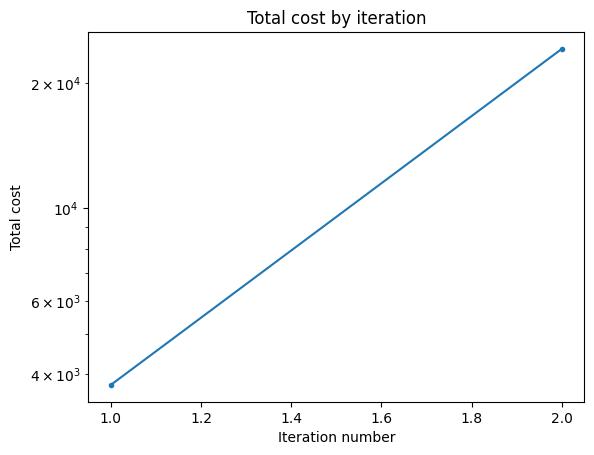

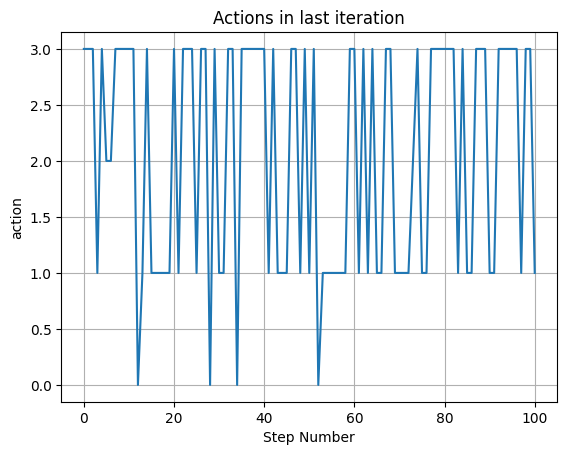

In [48]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

Simulator = BoxCad_1d()

model = RLModel(
    dim_observation=Simulator.state_size,
    dim_action=4,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    scale_factor=1,  # TRY TO FIND scale_factor EMPIRICALLY
    dim_hidden=3, # TRY TO FIND dim_hidden EMPIRICALLY
    std=0.01 # TRY TO FIND STD EMPIRICALLY
    #---------------------------------------------------------------------------
)

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.05) # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

scenario = MonteCarloSimulationScenario(
    simulator=Simulator,
    policy=policy,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    N_episodes=5, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=2, # You can change the number of iterations if you want
    #---------------------------------------------------------------------------
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=1, # do not change this
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

# clear_output(wait=True)
scenario.plot_data()

In [143]:
simulator = BoxCad_1d() #(device)


tensor(0, device='cuda:0')


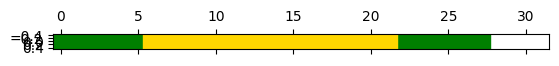

In [158]:
act = 0
simulator.receive_action(act)
simulator.step()
print(simulator.current_objective)
# print(simulator.task_lines)
# print(simulator.current_line)

simulator.render()

In [10]:
simulator.current_line

tensor([40, 30], device='cuda:0')

In [34]:
simulator.workspace_tasks

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [35]:
simulator.workspace_current_line

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [42]:
simulator.current_objective

tensor(20, device='cuda:0')

In [47]:
simulator.receive_action(0)
simulator.step()

True